In [6]:
%load_ext autoreload
%autoreload 2
%connect_info
%pprint 1
# General imports
from graphviz import Digraph
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from typing import NamedTuple, List, Tuple, Set, Optional
from collections import deque
from dataclasses import dataclass
from gt.solutions.br import BrownRobinsonOptimizer
from IPython.display import display

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


import os

os.environ['PATH'] += r';D:\dev\graphviz\bin'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{
  "shell_port": 60972,
  "iopub_port": 60973,
  "stdin_port": 60974,
  "control_port": 60975,
  "hb_port": 60976,
  "ip": "127.0.0.1",
  "key": "ba1b68f1-7cdbc5d076e8c9eb403006d6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e51b5860-f2a4-4ba3-9d44-a8c33f7dcd2a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
Pretty printing has been turned OFF


In [99]:
class GameNode:
    
    def __init__(self, player: int, parent: Optional['GameNode'], is_leaf: bool=False, layer: int=-1, name=''):
        self.player = player
        self.parent = parent
        self.is_leaf = is_leaf
        self.layer = layer
        self.name = name
        self.children = []
        self.optimal_children = []
        self.payoffs = []

    def check_children_payoffs(self):
        for child in self.children:
            if not len(child.payoffs):
                return False
        return True

    def get_children_payoffs(self):
        res = []
        for child in self.children:
            for gain in child.payoffs:
                res.append(gain)
        return list(zip(*res))[self.player]

    def solve(self):
        max_gain = max(self.get_children_payoffs())

        for child in self.children:
            for payoff in child.payoffs:
                if payoff[self.player] == max_gain:
                    if not (child in self.optimal_children):
                        self.optimal_children.append(child)
                        self.payoffs.append(payoff)

    @property
    def is_optimal(self):
        current = self
        while current:
            if current.parent and current not in current.parent.optimal_children:
                return False
            current = current.parent
        return True


class GameTree:
    COLORS = ["red", "green", "blue", "orange", "pink", "brown"]
    
    def __init__(self, root: GameNode):
        self.root = root

    def iterleafs(self):
        for node in self.iternodes():
            if node.is_leaf:
                yield node
    
    @classmethod
    def generate_game(cls, players: int, limits: Tuple[int, int], 
                      leaf_probability: float, max_depth: int, max_strategies: int) -> 'GameTree':
        logger.info(f"Generating game with {players} players...")
        first_player = np.random.randint(0, players)
        logger.debug(f"First player is {first_player}")
        root = GameNode(first_player, None, False, 0)
        to_make = deque([root])

        def mknode(node: GameNode):
            if node.parent is not None:
                node.layer = node.parent.layer + 1
            if np.random.random() < leaf_probability or node.layer >= max_depth:
                node.is_leaf = True
            if node.player is None:
                node.player = ((0 if node.is_leaf else 1) + node.parent.player) % players
            if node.is_leaf:
                node.payoffs.append(np.random.randint(*limits, size=(1, players)).ravel())
            else:
                strategies = np.random.randint(2, max_strategies+1)
                node.children = [GameNode(None, node) for _ in range(strategies)]
        
        i = 0
        while len(to_make):
            node = to_make.popleft()
            node.name = f'{i}'
            mknode(node)
            if node.layer <= max_depth:
                to_make.extend(node.children)
                i += 1
        logger.info(f"Generated {i} nodes...")
        return GameTree(root)

    
    def iternodes(self):
        node_queue = deque()
        node_queue.append(self.root)

        while len(node_queue):
            node = node_queue.popleft()
            yield node
            for child in node.children:
                node_queue.append(child)

    def solve(self):
        node_queue = deque(self.iterleafs())

        while len(node_queue):
            current_node = node_queue.popleft()

            if (len(current_node.payoffs) and current_node.parent):
                logger.info(f"Node {current_node.name} already has a calculated payoff and a parent")
                node_queue.append(current_node.parent)
                continue

            if not current_node.check_children_payoffs():
                node_queue.append(current_node)
                continue

            current_node.solve()

    def draw(self):
        graph = Digraph("Game")
        for node in self.iternodes():
            node_label = f"Player {node.player}"
            if len(node.payoffs):
                payoffs = '\n'.join([str(p) for p in node.payoffs])
                node_label += f"\nPayoffs:\n{payoffs}"

            graph.node(node.name, f"[{node.name}] {node_label}")

        for node in self.iternodes():
            for child in node.children:
                if not child.is_optimal:
                    graph.edge(node.name, child.name)

        optimal_color = -1
        for leaf in self.iterleafs():
            node = leaf
            if leaf.is_optimal:
                optimal_color += 1
            while node and leaf.is_optimal:
                if node.parent:
                    graph.edge(node.parent.name, node.name, color=self.COLORS[optimal_color])
                node = node.parent        
        return graph


12:21:55 INFO:Generating game with 2 players...
12:21:55 DEBUG:First player is 1
12:21:55 INFO:Generated 12 nodes...
12:21:55 INFO:Node 4 already has a calculated payoff and a parent
12:21:55 INFO:Node 5 already has a calculated payoff and a parent
12:21:55 INFO:Node 6 already has a calculated payoff and a parent
12:21:55 INFO:Node 7 already has a calculated payoff and a parent
12:21:55 INFO:Node 8 already has a calculated payoff and a parent
12:21:55 INFO:Node 9 already has a calculated payoff and a parent
12:21:55 INFO:Node 10 already has a calculated payoff and a parent
12:21:55 INFO:Node 11 already has a calculated payoff and a parent
12:21:55 INFO:Node 1 already has a calculated payoff and a parent
12:21:55 INFO:Node 1 already has a calculated payoff and a parent
12:21:55 INFO:Node 2 already has a calculated payoff and a parent
12:21:55 INFO:Node 2 already has a calculated payoff and a parent
12:21:55 INFO:Node 3 already has a calculated payoff and a parent


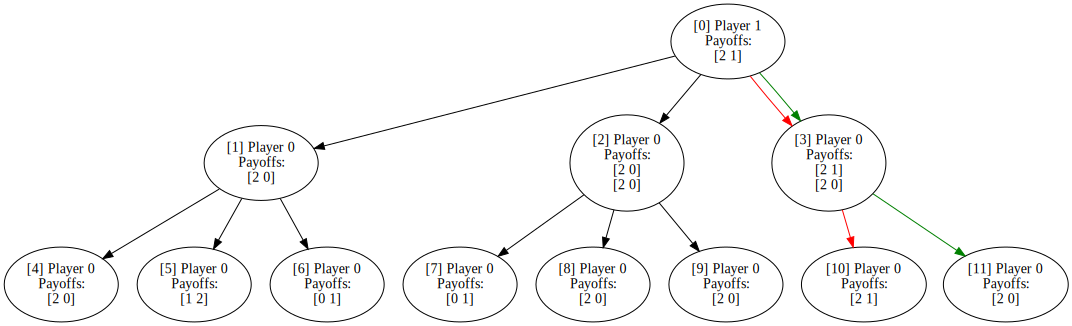

In [116]:
tree = GameTree.generate_game(2, limits=(0, 3), leaf_probability=0, max_depth=2, max_strategies=3)
tree.draw()
tree.solve()
graph = tree.draw()
graph.format = 'png'
graph.render('graph')
display(graph)